# Homework Assignment  5

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (60pt). 
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

In [1]:
import networkx as nx
import pandas as pd
import turicreate as tc
import operator
import random
import os, re
from glob import glob
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
df = pd.read_csv('LINUX_ORGEDGES.csv',index_colvvccv0)
g = nx.from_pandas_adjacency(df)
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 645
Number of edges: 3172
Average degree:   9.8357


In [36]:
def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]

def select_random_non_existing_links(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        u = random.choice(v_list)
        v = random.choice(v_list)
        if g.has_edge(u,v) or (u,v) in select_links:
            continue
        else:
            select_links.add((u,v))
    return list(select_links)
            
    
postive_links = select_random_existing_links(g,2500)
negative_links = select_random_non_existing_links(g,10000)



In [37]:
def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

def friends_measure(g, u,v):
    s = 0
    for x in g.neighbors(u):
        for y in g.neighbors(v):
                s += 1
    return s

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            'jaccard_coefficient': list(nx.jaccard_coefficient(g,[(u,v)]))[0][2],
            'adamic_adar_index': list(nx.adamic_adar_index(g,[(u,v)]))[0][2],
            'friends_measure': friends_measure(g, u,v)
        }
    except:
        print('err')
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d



In [38]:
links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)
links_features[0]

err
err
err
err



{'degree_v': 47,
 'degree_u': 47,
 'total_friends': 47,
 'common_friends': 47,
 'jaccard_coefficient': 1.0,
 'adamic_adar_index': 12.139566444321995,
 'friends_measure': 2209,
 'class': True}

In [40]:
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'jaccard_coefficient', 'adamic_adar_index', 'friends_measure', 'class' ]
data_dict = {f:[] for f in features_list}
 
for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)
sf.print_rows(3000)

+--------------------+-------+----------------+----------+----------+-----------------+
| adamic_adar_index  | class | common_friends | degree_u | degree_v | friends_measure |
+--------------------+-------+----------------+----------+----------+-----------------+
| 12.139566444321995 |   1   |       47       |    47    |    47    |       2209      |
| 12.139566444321995 |   1   |       47       |    47    |    47    |       2209      |
| 3.6028696846181765 |   1   |       8        |    8     |    8     |        64       |
|        0.0         |   1   |       0        |    0     |    0     |        0        |
| 7.445453375935946  |   1   |       24       |    24    |    24    |       576       |
| 5.4101064033336135 |   1   |       15       |    15    |    15    |       225       |
|        0.0         |   1   |       0        |    0     |    3     |        0        |
| 7.456019214715338  |   1   |       24       |    24    |    27    |       648       |
| 2.601711879273844  |   1   |  

In [41]:
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'jaccard_coefficient', 'adamic_adar_index', 'friends_measure' ]
cls = tc.classifier.create(train,features=features_list, target="class")

Train size 10026
Test size: 2470
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 9510

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.031880     | 0.999474          | 1.000000            | 0.438307          | 0.437972            |

| 2         | 0.058758     | 0.999474          | 1.000000            | 0.297501          | 0.296911            |

| 3         | 0.082338     | 0.999474          | 1.000000            | 0.208801          | 0.207994            |

| 4         | 0.109053     | 0.999474          | 1.000000            | 0.149494          | 0.148492            |

| 5         | 0.131317     | 0.999474          | 1.000000            | 0.108492          | 0.107309            |

| 10        | 0.273997     | 0.999474          | 1.000000            | 0.025044          | 0.023276            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 9510

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.034623     | 0.998948          | 0.998062            | 0.129854          | 0.131556            |

| 2         | 0.059509     | 0.999159          | 0.998062            | 0.128992          | 0.128744            |

| 3         | 0.084764     | 0.999474          | 1.000000            | 0.128853          | 0.128210            |

| 4         | 0.108033     | 0.999474          | 1.000000            | 0.128786          | 0.127993            |

| 5         | 0.131904     | 0.999474          | 1.000000            | 0.128750          | 0.127883            |

| 10        | 0.261992     | 0.999369          | 1.000000            | 0.128747          | 0.127870            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 9510

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.031468     | 0.999474          | 1.000000            | 0.128564          | 0.127479            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 9510

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

Number of coefficients    : 8

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.111397     | 0.993586          | 0.994186            |

| 1         | 4        | 1.000000  | 0.243796     | 0.917771          | 0.928295            |

| 2         | 9        | 0.299882  | 0.508530     | 0.992639          | 0.994186            |

| 3         | 10       | 0.374852  | 0.602842     | 0.992639          | 0.994186            |

| 4         | 12       | 0.374852  | 0.736571     | 0.993375          | 0.994186            |

| 9         | 22       | 1.874262  | 1.445094     | 0.993586          | 0.994186            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 9510

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

Number of coefficients      : 8

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.128833     | 0.994006          | 0.994186            |

| 2         | 3        | 0.214823     | 0.994006          | 0.994186            |

| 3         | 4        | 0.306325     | 0.994006          | 0.994186            |

| 4         | 5        | 0.379456     | 0.994217          | 0.994186            |

| 5         | 6        | 0.478118     | 0.994217          | 0.994186            |

| 10        | 11       | 0.912616     | 0.993901          | 0.994186            |

+-----------+----------+--------------+-------------------+---------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 1.0
PROGRESS: RandomForestClassifier          : 1.0
PROGRESS: DecisionTreeClassifier          : 1.0
PROGRESS: SVMClassifier                   : 0.9941860465116279
PROGRESS: LogisticClassifier              : 0.9941860465116279
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [42]:
results = cls.evaluate(test)
results

{'accuracy': 0.9991902834008097,
 'auc': 0.9990372144696786,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |   1   |
 |      1       |        1        |  532  |
 |      0       |        1        |   1   |
 |      0       |        0        |  1936 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.99812382739212,
 'log_loss': 0.02620438544262102,
 'precision': 0.99812382739212,
 'recall': 0.99812382739212,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+-----+------+
 | threshold | fpr | tpr |  p  |  n   |
 +-----------+-----+-----+-----+------+
 |    0.0    | 1.0 | 1.0 | 533 | 1937 |
 |   1e-05   | 1.0 | 1.0 | 533 | 1937 |
 |   2e-05   | 1.0 | 1.0 | 53

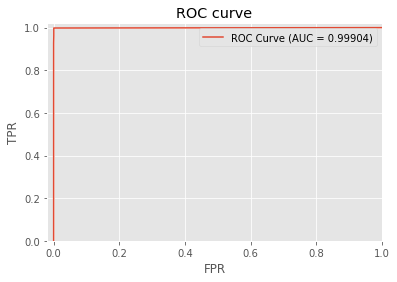

In [43]:
plt.style.use('ggplot')
plt.plot(results['roc_curve']['fpr'],
         results['roc_curve']['tpr'],
         label='ROC Curve (AUC = %0.5f)' %results['auc'])

plt.xlim([-0.02, 1.0])
plt.ylim([0., 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

In [44]:
cls.classify(test)

class,probability
1,0.9756473302841187
1,0.9585659503936768
1,0.9756473302841187
1,0.9645815491676331
1,0.9756473302841187
1,0.9756473302841187
1,0.9756473302841187
1,0.9756473302841187
1,0.9756473302841187
1,0.9734687209129333


In [45]:
cls = tc.classifier.create(train,features=["common_friends"], target="class")
results = cls.evaluate(test)
results

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 9468

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.032497     | 0.993663          | 0.994624            | 0.444008          | 0.443313            |

| 2         | 0.061629     | 0.993663          | 0.994624            | 0.306695          | 0.305590            |

| 3         | 0.090041     | 0.993663          | 0.994624            | 0.220664          | 0.219275            |

| 4         | 0.117598     | 0.993663          | 0.994624            | 0.163593          | 0.161996            |

| 5         | 0.142120     | 0.993663          | 0.994624            | 0.124560          | 0.122806            |

| 10        | 0.299109     | 0.993663          | 0.994624            | 0.048942          | 0.046883            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 9468

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.036714     | 0.993663          | 0.994624            | 0.142568          | 0.140885            |

| 2         | 0.071661     | 0.993663          | 0.994624            | 0.142388          | 0.140687            |

| 3         | 0.102527     | 0.993663          | 0.994624            | 0.142426          | 0.140726            |

| 4         | 0.131191     | 0.993663          | 0.994624            | 0.142439          | 0.140748            |

| 5         | 0.157549     | 0.993663          | 0.994624            | 0.142427          | 0.140737            |

| 10        | 0.285095     | 0.993557          | 0.994624            | 0.142419          | 0.140701            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 9468

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.032901     | 0.993663          | 0.994624            | 0.142274          | 0.140591            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 9468

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 5.000000  | 0.031525     | 0.896599          | 0.887097            |

| 1         | 6        | 2.500000  | 0.044640     | 0.945923          | 0.942652            |

| 2         | 13       | 0.090389  | 0.080649     | 0.957541          | 0.956989            |

| 3         | 17       | 0.271168  | 0.114898     | 0.957541          | 0.956989            |

| 4         | 18       | 0.338960  | 0.125743     | 0.961977          | 0.962366            |

| 9         | 27       | 1.694800  | 0.215232     | 0.990177          | 0.992832            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 9468

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

Number of coefficients      : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.008922     | 0.896599          | 0.887097            |

| 2         | 3        | 0.025488     | 0.931348          | 0.924731            |

| 3         | 4        | 0.040848     | 0.945923          | 0.942652            |

| 4         | 5        | 0.054839     | 0.970110          | 0.973118            |

| 5         | 6        | 0.065955     | 0.976553          | 0.982079            |

| 10        | 11       | 0.133279     | 0.985953          | 0.991039            |

+-----------+----------+--------------+-------------------+---------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.9946236559139785
PROGRESS: RandomForestClassifier          : 0.9946236559139785
PROGRESS: DecisionTreeClassifier          : 0.9946236559139785
PROGRESS: SVMClassifier                   : 0.992831541218638
PROGRESS: LogisticClassifier              : 0.9910394265232975
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


{'accuracy': 0.9931174089068826,
 'auc': 0.9867980213498175,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        1        |  519  |
 |      1       |        0        |   14  |
 |      0       |        1        |   3   |
 |      0       |        0        |  1934 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.9838862559241707,
 'log_loss': 0.0510910818129119,
 'precision': 0.9942528735632183,
 'recall': 0.9737335834896811,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+-----+------+
 | threshold | fpr | tpr |  p  |  n   |
 +-----------+-----+-----+-----+------+
 |    0.0    | 1.0 | 1.0 | 533 | 1937 |
 |   1e-05   | 1.0 | 1.0 | 533 | 1937 |
 |   2e-05   | 1.0 | 1.0

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

In [26]:
## iused the employee file and took all people whos jub listed as "manger" as the question wants. i did not take into account CEO
## VP and others - so this is why the precision is low.
enron_manager_set = set(['chris.dorland@enron.com','cooper.richey@enron.com','daren.farmer@enron.com','jeff.king@enron.com'
                         ,'j..farmer@enron.com','j..kaminski@enron.com','j.kaminski@enron.com',
                       'john.forney@enron.com','k..allen@enron.com','martin.cuilla@enron.com','m..forney@enron.com',
                         'mike.carson@enron.com','mike.grigsby@enron.com','phillip.allen@enron.com',
                      'rick.buy@enron.com','teb.lokey@enron.com','vince.kaminski@enron.com']) 

In [5]:
enron_data_set_path = "../datasets/enron/maildir"

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()
files_list = [p for p in glob(f"{enron_data_set_path}/*/*/*") if "/inbox/" in p or "/sent/" in p]
print("Found %s files" % len(files_list))
for i in tqdm(range(len(files_list))):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

g = nx.DiGraph()    

Found 99279 files


In [35]:
def eval_find_manger(ls,manager_set):
    count = 0
    for var in ls:
        if var[0] in manager_set:   
            count+=1
    print(f'precision @10 is {count//10}')

In [41]:
g = nx.DiGraph()
g.add_edges_from(links)
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 18590\nNumber of edges: 32392\nAverage in degree:   1.7424\nAverage out degree:   1.7424'

In [8]:
degree_nodes = nx.centrality.degree_centrality(G=g)
between_nodes = nx.betweenness_centrality(g)
closeness_nodes = nx.closeness_centrality(g)

In [36]:
h_employees = sorted(degree_nodes.items(), key=operator.itemgetter(1), reverse=True)
top10_degree = h_employees[:10]
eval_find_manger(top10_degree,enron_manager_set)

precision @10 is 0


In [37]:
h_employees = sorted(between_nodes.items(), key=operator.itemgetter(1), reverse=True)
top10_between = h_employees[:10]
eval_find_manger(top10_between,enron_manager_set)

precision @10 is 0


In [38]:
h_employees = sorted(closeness_nodes.items(), key=operator.itemgetter(1), reverse=True)
top10_closeness = h_employees[:10]
eval_find_manger(top10_closeness,enron_manager_set)

precision @10 is 0


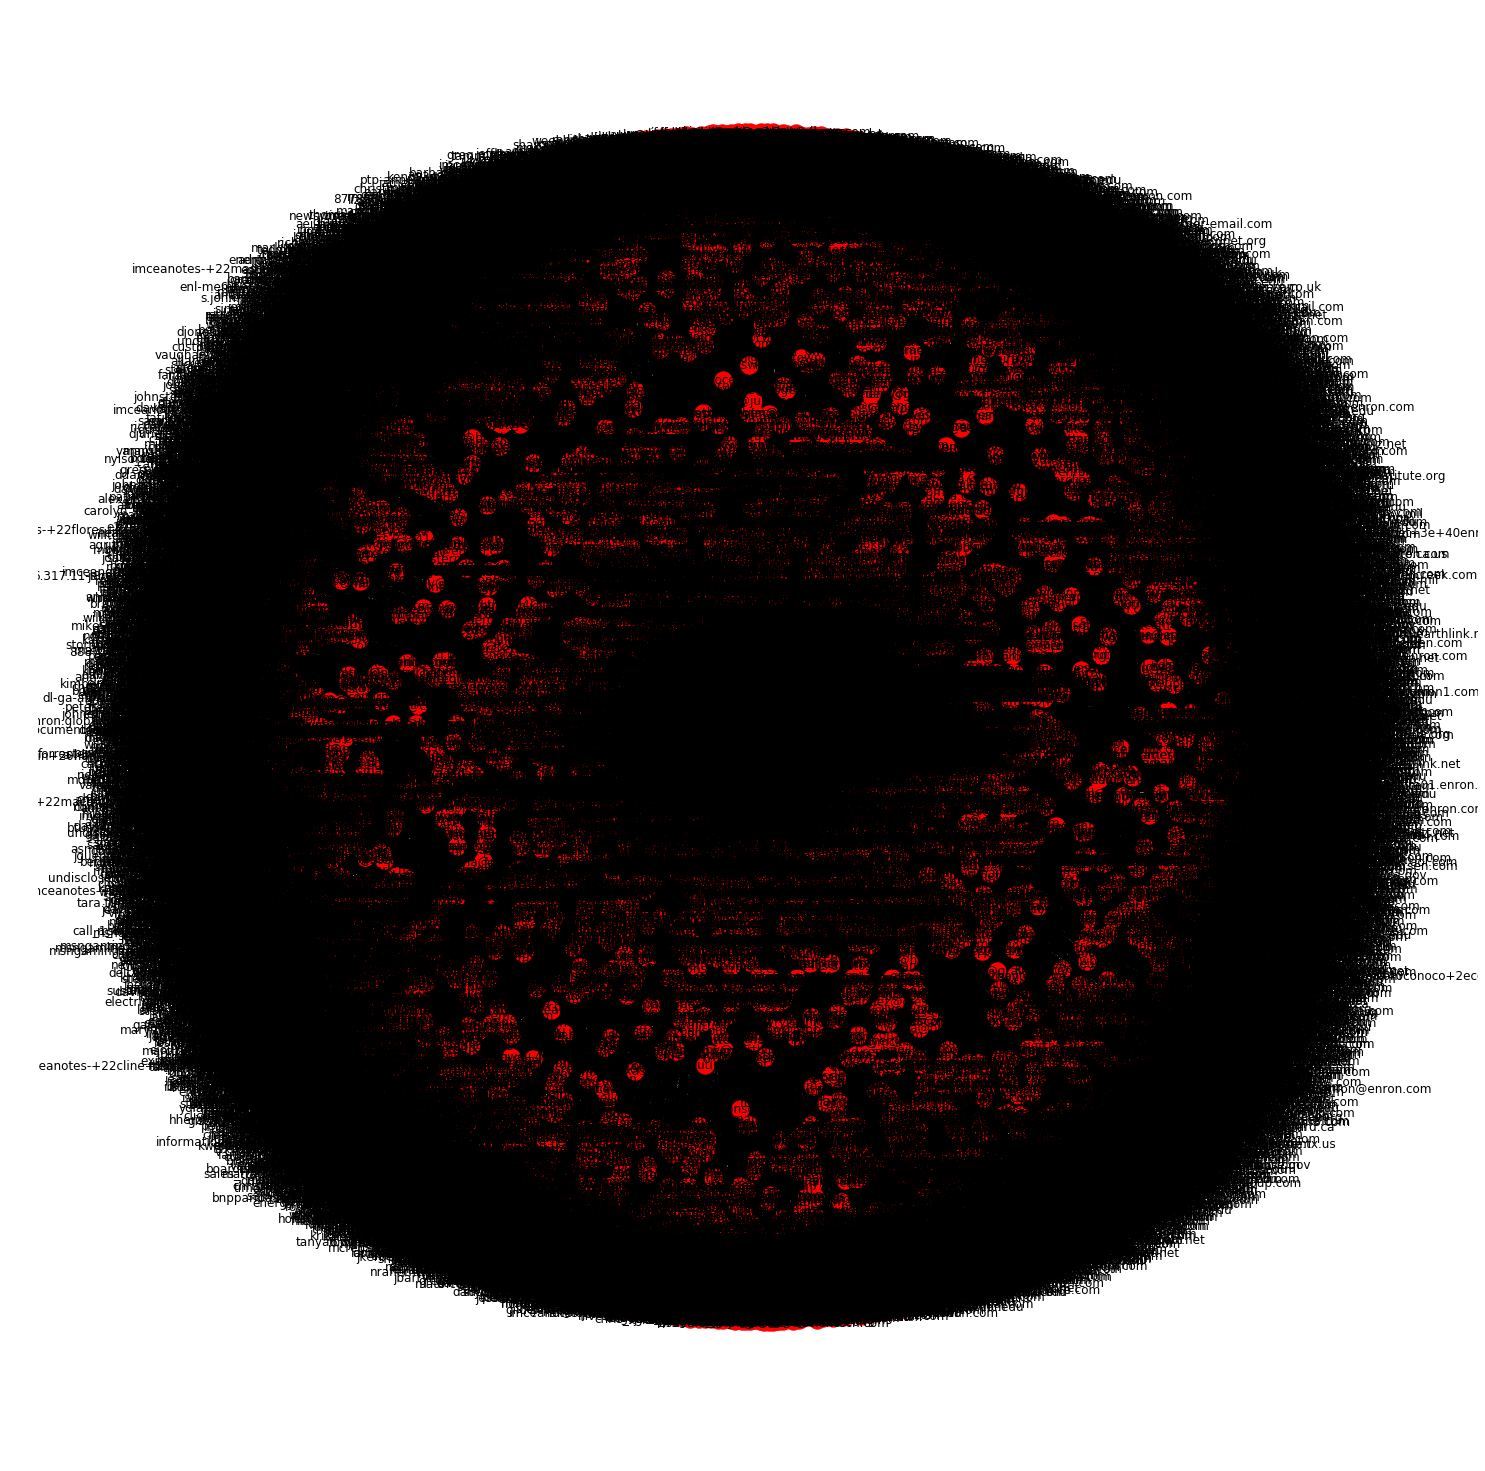

In [44]:
l = [n for n,degree in degree_nodes.items()]
h = g.subgraph(l)
plt.figure(figsize=(20,20))
nx.draw_spring(h, with_labels=True)